In [55]:
import pandas as pd
import numpy as np
import yfinance as yf
from datetime import date
from prophet import Prophet
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
from prophet.diagnostics import cross_validation, performance_metrics

In [56]:
ticker = 'NG=F'
start_dt = '2010-01-01'
end_dt = date.today().strftime('%Y-%m-%d')
ng_df = yf.download(ticker, start=start_dt, end=end_dt, multi_level_index=False)
ng_df.reset_index(inplace=True)

[*********************100%***********************]  1 of 1 completed


In [57]:
ng_df.sample(5)

,Date,Close,High,Low,Open,Volume
447,2011-10-11,3.616,3.627,3.513,3.562,190172
3311,2023-03-03,3.009,3.027,2.772,2.789,185066
24,2010-02-08,5.401,5.680,5.396,5.602,140790
98,2010-05-25,4.051,4.082,3.986,4.045,46069
784,2013-02-14,3.163,3.309,3.135,3.297,211043


In [58]:
prophet_df = ng_df.rename(columns={'Date': 'ds', 'Close': 'y'})
prophet_df['y'] = prophet_df['y'].astype(float)

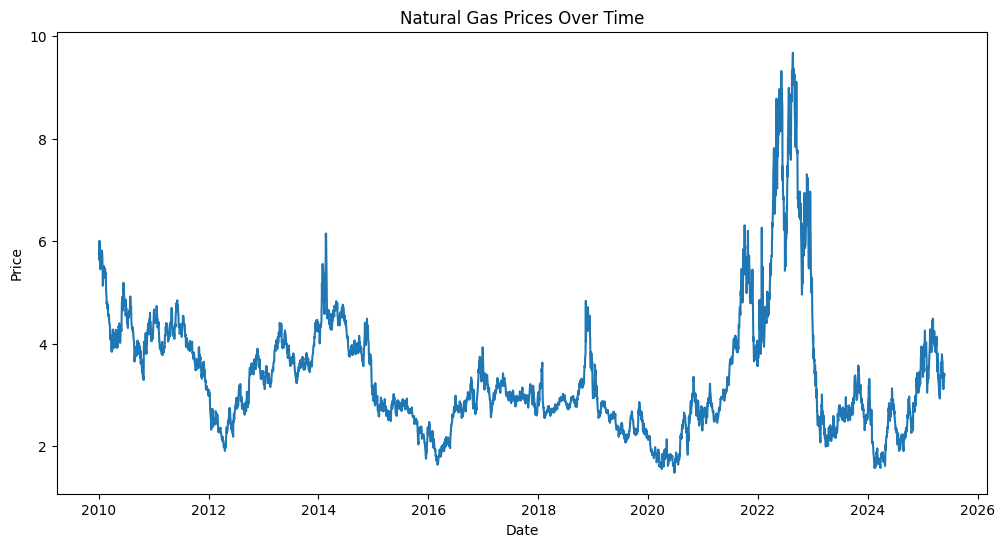

In [59]:
plt.figure(figsize=(12,6))
plt.plot(prophet_df['ds'], prophet_df['y'])
plt.title("Natural Gas Prices Over Time")
plt.xlabel("Date")
plt.ylabel("Price")
plt.show()

In [60]:
prophet_df.head()

,ds,y,High,Low,Open,Volume
0,2010-01-04,5.884,5.894,5.705,5.705,78858
1,2010-01-05,5.637,5.858,5.615,5.837,99492
2,2010-01-06,6.009,6.075,5.650,5.690,140611
3,2010-01-07,5.806,6.108,5.763,6.033,135113
4,2010-01-08,5.749,5.853,5.621,5.827,101153


In [61]:
test_size = 90  # last 90 days for testing
train_df = prophet_df[:-test_size]
test_df = prophet_df[-test_size:]

In [62]:
#  %% Initialize and Train Prophet with Hyperparameter Tuning
model = Prophet(
    seasonality_mode='multiplicative',
    daily_seasonality=True,
    yearly_seasonality=True,
    weekly_seasonality=True,
    changepoint_range=0.95,
    changepoint_prior_scale=0.2  # Increased flexibility
)
# Add custom seasonalities
model.add_seasonality(name='monthly', period=30.5, fourier_order=5)

In [63]:
model.fit(train_df)

12:57:15 - cmdstanpy - INFO - Chain [1] start processing
12:57:23 - cmdstanpy - INFO - Chain [1] done processing


In [64]:
# Make predictions for test period
future = model.make_future_dataframe(periods=test_size)
forecast = model.predict(future)

In [65]:
future = model.make_future_dataframe(periods=test_size)
forecast = model.predict(future)

In [66]:
forecast_test = forecast[['ds', 'yhat']].merge(test_df[['ds', 'y']], on='ds', how='inner')
predicted = forecast_test['yhat'].values
actual = forecast_test['y'].values

In [67]:
# Evaluate
rmse = np.sqrt(mean_squared_error(actual, predicted))
mae = mean_absolute_error(actual, predicted)

print(f"Prophet Test RMSE: {rmse:.4f}")
print(f"Prophet Test MAE : {mae:.4f}")

Prophet Test RMSE: 0.8043
Prophet Test MAE : 0.7162


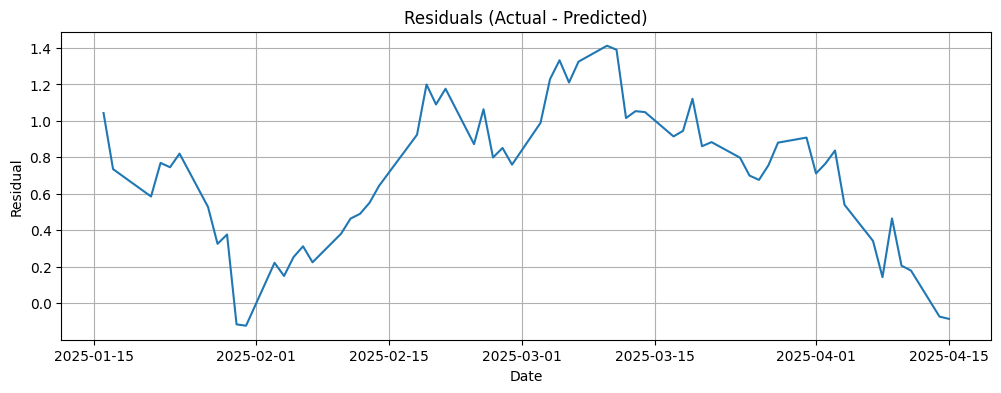

In [68]:
residuals = actual - predicted
plt.figure(figsize=(12,4))
plt.plot(forecast_test['ds'], residuals)
plt.title("Residuals (Actual - Predicted)")
plt.xlabel("Date")
plt.ylabel("Residual")
plt.grid(True)
plt.show()


In [69]:
print("Performing cross-validation...")
df_cv = cross_validation(model, initial='730 days', period='180 days', horizon='90 days')
metrics = performance_metrics(df_cv)
print(metrics)

Performing cross-validation...


  0%|          | 0/26 [00:00<?, ?it/s]

12:57:26 - cmdstanpy - INFO - Chain [1] start processing
12:57:28 - cmdstanpy - INFO - Chain [1] done processing
12:57:29 - cmdstanpy - INFO - Chain [1] start processing
12:57:30 - cmdstanpy - INFO - Chain [1] done processing
12:57:30 - cmdstanpy - INFO - Chain [1] start processing
12:57:32 - cmdstanpy - INFO - Chain [1] done processing
12:57:33 - cmdstanpy - INFO - Chain [1] start processing
12:57:34 - cmdstanpy - INFO - Chain [1] done processing
12:57:34 - cmdstanpy - INFO - Chain [1] start processing
12:57:37 - cmdstanpy - INFO - Chain [1] done processing
12:57:37 - cmdstanpy - INFO - Chain [1] start processing
12:57:40 - cmdstanpy - INFO - Chain [1] done processing
12:57:40 - cmdstanpy - INFO - Chain [1] start processing
12:57:42 - cmdstanpy - INFO - Chain [1] done processing
12:57:43 - cmdstanpy - INFO - Chain [1] start processing
12:57:44 - cmdstanpy - INFO - Chain [1] done processing
12:57:44 - cmdstanpy - INFO - Chain [1] start processing
12:57:47 - cmdstanpy - INFO - Chain [1]

   horizon       mse      rmse       mae      mape     mdape     smape  \
0   9 days  0.514385  0.717206  0.443682  0.119981  0.079480  0.129482   
1  10 days  0.543034  0.736908  0.461599  0.121819  0.079480  0.130331   
2  11 days  0.572256  0.756476  0.475195  0.124157  0.087796  0.131540   
3  12 days  0.592141  0.769507  0.485550  0.129083  0.089342  0.137448   
4  13 days  0.567594  0.753388  0.488780  0.133414  0.094591  0.143001   
..     ...       ...       ...       ...       ...       ...       ...   
77 86 days  3.055004  1.747857  1.163105  0.365442  0.217850  0.392474   
78 87 days  3.215806  1.793267  1.164442  0.362621  0.208195  0.381329   
79 88 days  3.410363  1.846717  1.181063  0.365144  0.213228  0.378604   
80 89 days  3.677362  1.917645  1.218959  0.378843  0.213228  0.388411   
81 90 days  3.745397  1.935303  1.223513  0.382279  0.223321  0.391665   

    coverage  
0   0.537736  
1   0.527932  
2   0.525157  
3   0.530398  
4   0.517378  
..       ...  
77  0.

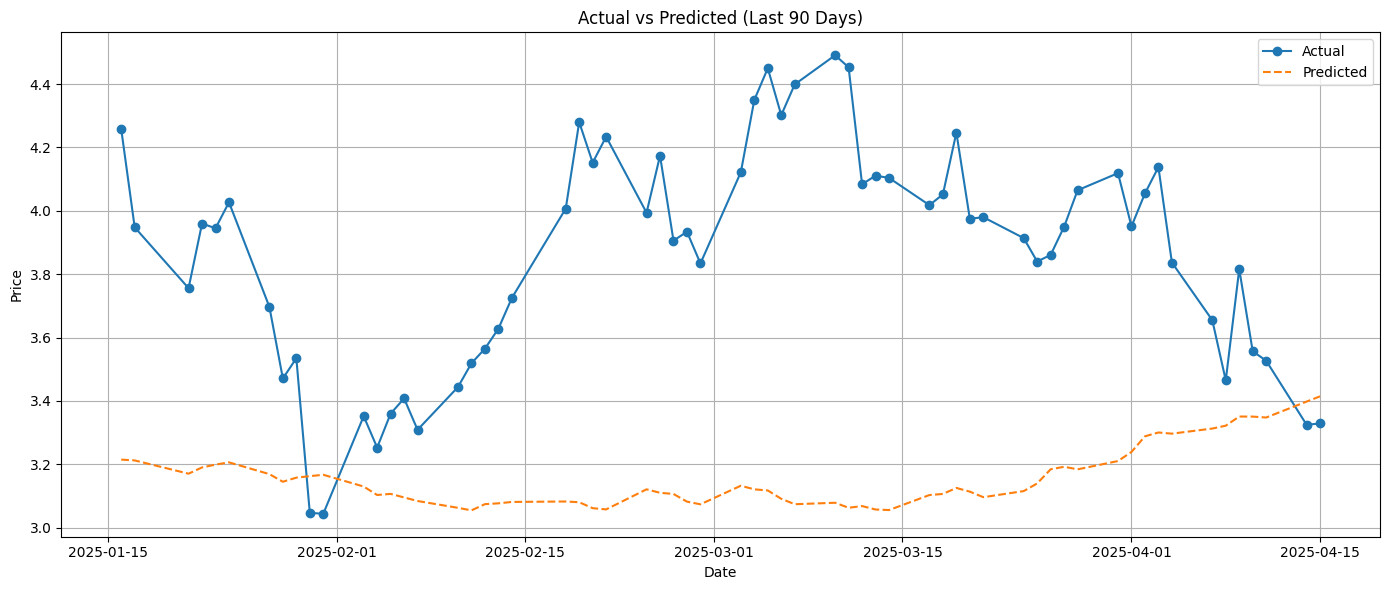

In [70]:
plt.figure(figsize=(14,6))
plt.plot(forecast_test['ds'], actual, label='Actual', marker='o')
plt.plot(forecast_test['ds'], predicted, label='Predicted', linestyle='--')
plt.title("Actual vs Predicted (Last 90 Days)")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [71]:
future_full_days = 30
future_full = model.make_future_dataframe(periods=future_full_days)
forecast_full = model.predict(future_full)

<Figure size 1800x600 with 0 Axes>

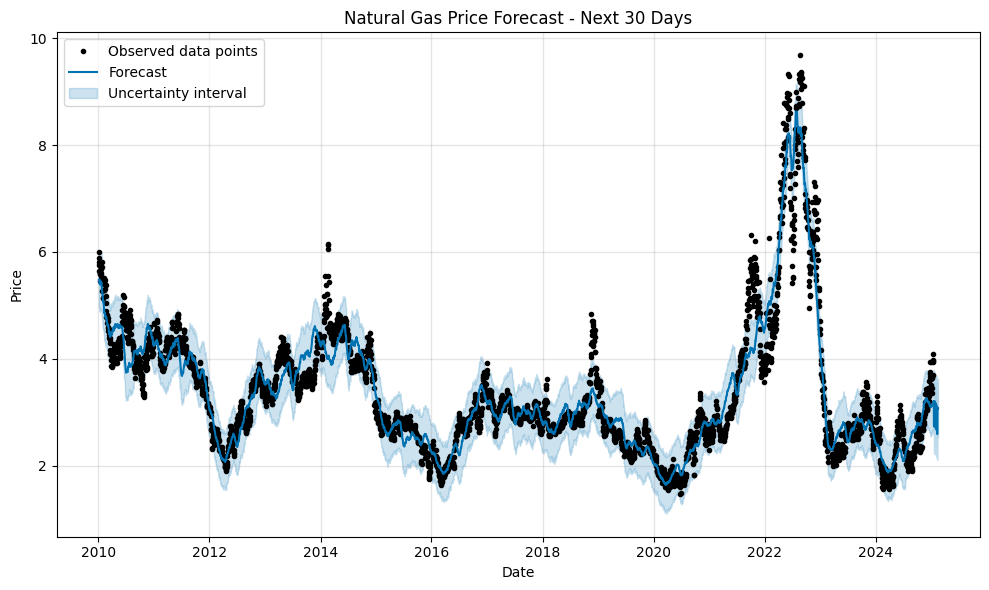

In [78]:
plt.figure(figsize=(18,6))
model.plot(forecast_full)
plt.title(f"Natural Gas Price Forecast - Next {future_full_days} Days")
plt.xlabel("Date")
plt.ylabel("Price")
plt.grid(True)
plt.tight_layout()
plt.legend()
plt.show()

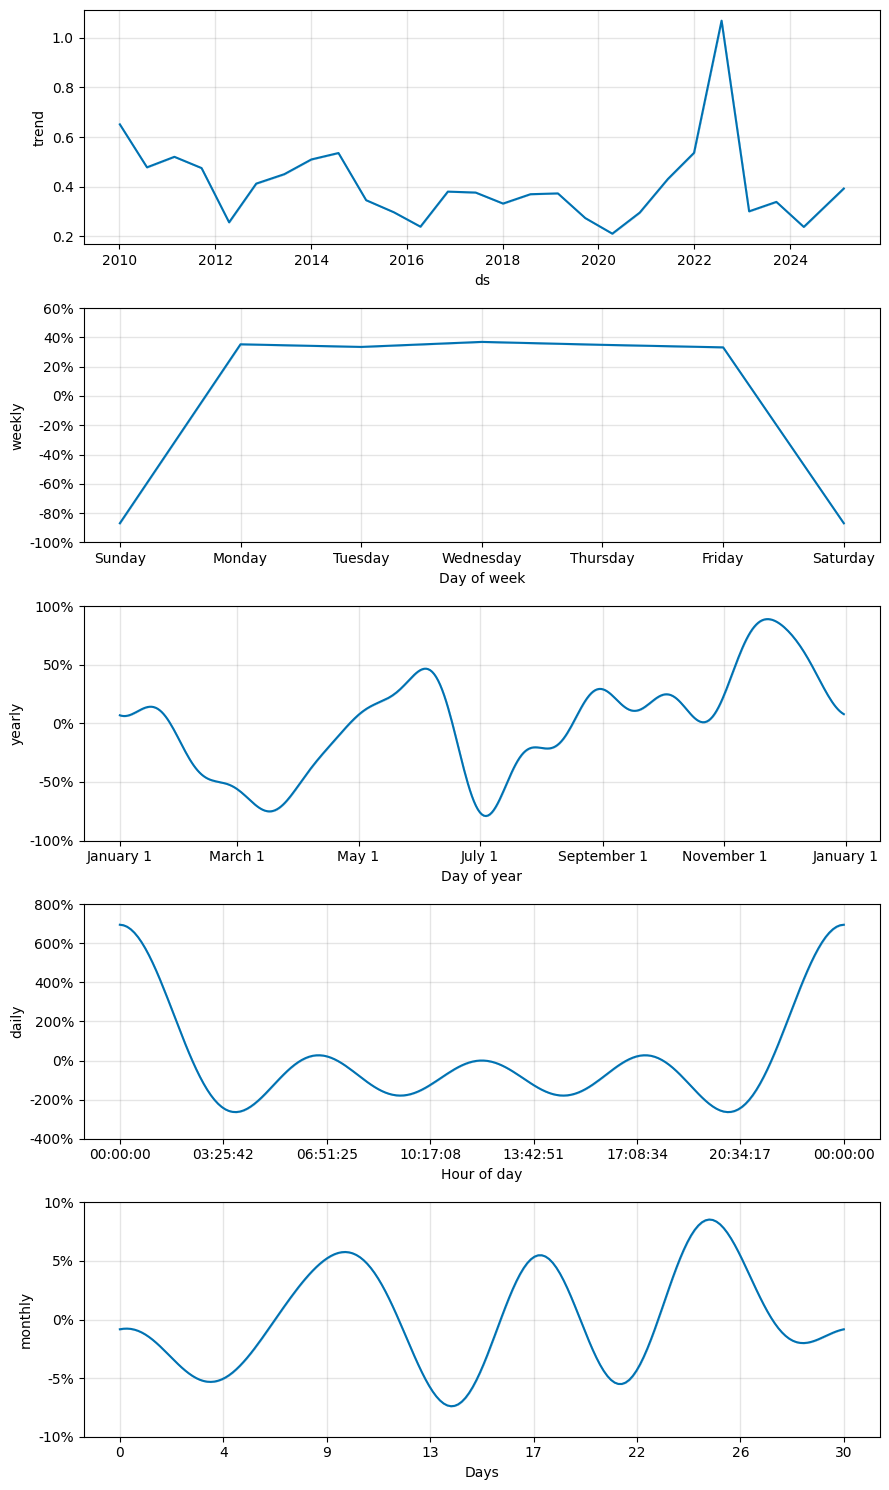

In [73]:
model.plot_components(forecast_full)
plt.tight_layout()
plt.show()

In [74]:
print(forecast_full[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(future_full_days))

             ds      yhat  yhat_lower  yhat_upper
3783 2025-01-16  3.214930    2.693916    3.792917
3784 2025-01-17  3.212413    2.712773    3.734351
3785 2025-01-18  2.751125    2.232044    3.281015
3786 2025-01-19  2.736312    2.230802    3.272745
3787 2025-01-20  3.184742    2.651786    3.674370
3788 2025-01-21  3.170609    2.692244    3.695149
3789 2025-01-22  3.190324    2.649817    3.712223
3790 2025-01-23  3.199190    2.701919    3.755263
3791 2025-01-24  3.206345    2.684444    3.743169
3792 2025-01-25  2.745348    2.236938    3.226887
3793 2025-01-26  2.726287    2.211217    3.181438
3794 2025-01-27  3.169204    2.639224    3.713103
3795 2025-01-28  3.145098    2.638348    3.651751
3796 2025-01-29  3.158079    2.640651    3.689908
3797 2025-01-30  3.162758    2.673142    3.672157
3798 2025-01-31  3.167152    2.670870    3.700502
3799 2025-02-01  2.700514    2.192356    3.221401
3800 2025-02-02  2.681888    2.158227    3.204727
3801 2025-02-03  3.130049    2.614967    3.690782
